<a href="https://www.kaggle.com/code/jonathanradcliffe/titanic-second-go?scriptVersionId=125537277" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


#  Titanic - Machine Learning from Disaster: Second Kaggle Competition!

#  Introduction

We use the Titanic passenger data in train.csv (name, age, price of ticket, etc) to try to predict who will survive and who will die in test.csv.

* We will first see what's missing from both train and test data. I would normally throw out anything with more than 15% data missing, but if we can explain why it's missing and fill in then we might keep the features. 
* We will explore the training data to get a sense of any coorelations between features & target and other features. 
* We will then look at training features in detail and see if there are any outliers or if feature engineering is possible.
* We will then check numeric features for normal distriubtions and transform if required.
* Finally before onehotencode catagorical features before building models.
* We will check unoptimized models for highest accuracy and auc-roc
* We will take the best models and peform gridsearch of optimizing hyper parameters
* Finally we will predict who survives!!!!

Many thanks to YASSINE GHOUZAM for a fair bit of the modeling ideas used here https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling

**Import Libraires**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, norm, skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import scikitplot as skplt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

from collections import Counter

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)

sns.set(style='white', context='notebook', palette='colorblind')

#  Read and explore the test & train data

In [3]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
train.dtypes.value_counts()

int64      5
object     5
float64    2
dtype: int64

In [7]:
test.dtypes.value_counts()

object     5
int64      4
float64    2
dtype: int64

#  Let's see what's missing and deal with it!
**Let's summarise what's missing and then review how to handle the missing data.**

In [8]:
missing_vals_train = pd.DataFrame(train.isna().sum(), columns=['Sum'])
missing_vals_train = missing_vals_train.sort_values(by = ['Sum'], ascending=False)
missing_vals_train = missing_vals_train[missing_vals_train['Sum']>0]
missing_vals_train['Percent'] = missing_vals_train['Sum']/891*100
missing_vals_train

,Sum,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


In [9]:
missing_vals_test = pd.DataFrame(test.isna().sum(), columns=['Sum'])
missing_vals_test = missing_vals_test.sort_values(by = ['Sum'], ascending=False)
missing_vals_test = missing_vals_test[missing_vals_test['Sum']>0]
missing_vals_test['Percent'] = missing_vals_test['Sum']/418*100
missing_vals_test

,Sum,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


<AxesSubplot:ylabel='Percent'>

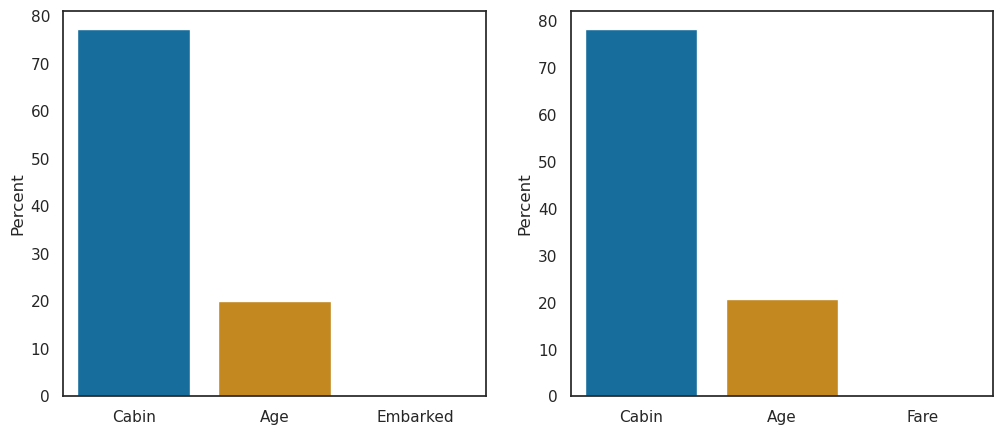

In [10]:
fig, ax = plt.subplots(1,2, figsize =(12, 5))
sns.barplot(x= missing_vals_train.index, y=missing_vals_train['Percent'], ax=ax[0])
sns.barplot(x= missing_vals_test.index, y=missing_vals_test['Percent'], ax=ax[1])

**According to the data dictionary, Cabin -> Cabin number. In both datasets Cabin is missing around 80% of the data. Let's drop it from both train & test**

In [11]:
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

**My initial reaction is to throw away the age data because ~20% of it is missing from both the train and test datasets. However let's take a closer look...**

**According to the data dictionary, Age -> Age in years. According to the Variable Notes, age: Age is fractional if less than 1**

<AxesSubplot:xlabel='Survived', ylabel='Age'>

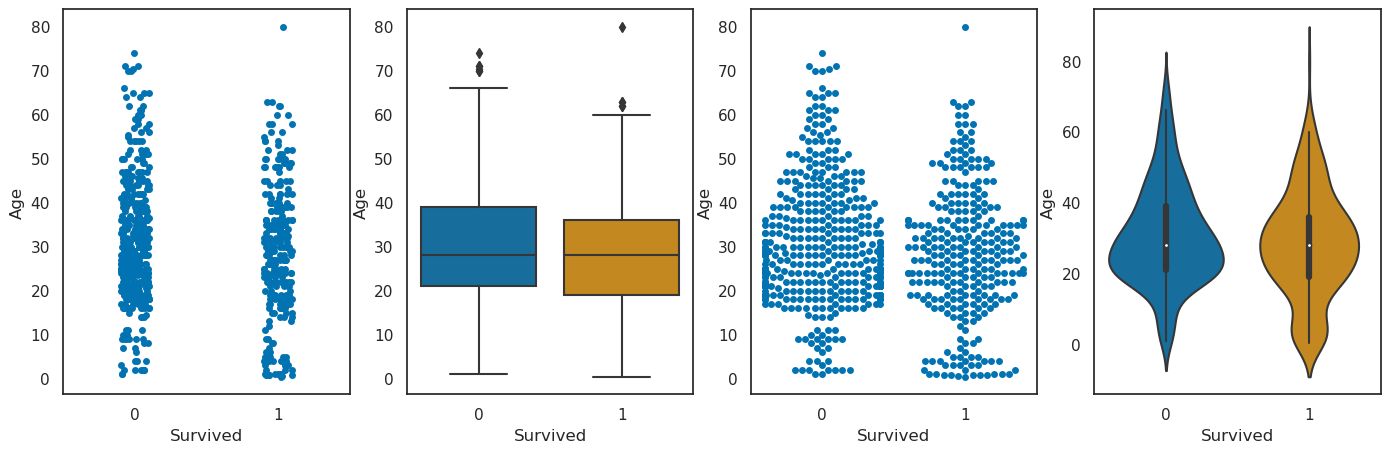

In [12]:
fig, ax = plt.subplots(1,4, figsize =(17, 5))
sns.stripplot(train, x = 'Survived', y='Age', ax=ax[0])
sns.boxplot(train, x = 'Survived', y='Age', ax=ax[1])
sns.swarmplot(train, x = 'Survived', y='Age', ax=ax[2])
sns.violinplot(train, x = 'Survived', y='Age', ax=ax[3])

**From the plots above we can see you are more likely to survive if younger than older. This looks most apparent on the extremes. So let's do the following:**
* Create a catagorical feature 'Over65'. If Age is >= 65 Over65 =1 and otherwise 0 (this includes when Age = Nan)
* Create a catagorical feature 'Under10'. If Age is <= 10 Under10 =1 and otherwise 0 (this includes when Age = Nan)
* Drop Age from both train and test. 

In [13]:
train['Over65'] = 0
train.loc[train['Age'] >= 65, 'Over65'] = 1
test['Over65'] = 0
test.loc[test['Age'] >= 65, 'Over65'] = 1

In [14]:
train['Under10'] = 0
train.loc[train['Age'] < 10, 'Under10'] = 1
test['Under10'] = 0
test.loc[test['Age'] < 10, 'Under10'] = 1

In [15]:
train = train.drop(['Age'], axis=1)
test = test.drop(['Age'], axis=1)

**Great! So we only have Embarked (train) and Fare (test) Nan remaining.**

**I would have thought Embarked should be coorelated with ticket number or if they had family on board, but not so.**

<AxesSubplot:xlabel='Embarked', ylabel='PassengerId'>

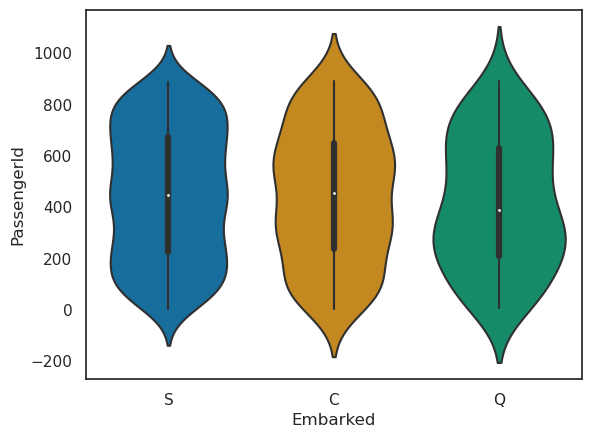

In [16]:
sns.violinplot(data=train, x='Embarked', y='PassengerId')

In [17]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

**Let's just replace Embarked NaN with the most frequent.**

In [18]:
train = train.fillna(train['Embarked'].value_counts().index[0])

<AxesSubplot:xlabel='Fare', ylabel='Density'>

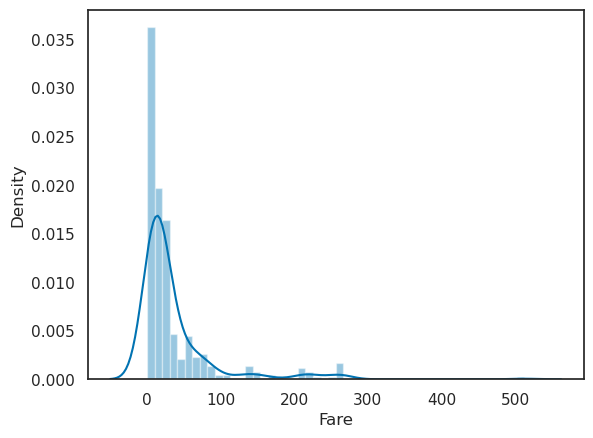

In [19]:
sns.distplot(test['Fare'])

In [20]:
print(test['Fare'].mean())
print(test['Fare'].median())
print(test['Fare'].mode())

35.627188489208635
14.4542
0    7.75
dtype: float64


**Let's just replace Fare NaN with the median.**

In [21]:
test['Fare'] = test['Fare'].fillna(value = test['Fare'].median())

In [22]:
missing_vals_train = pd.DataFrame(train.isna().sum(), columns=['Sum'])
missing_vals_train = missing_vals_train.sort_values(by = ['Sum'], ascending=False)
missing_vals_train = missing_vals_train[missing_vals_train['Sum']>0]
missing_vals_train['Percent'] = missing_vals_train['Sum']/891*100
missing_vals_train

,Sum,Percent


In [23]:
missing_vals_test = pd.DataFrame(test.isna().sum(), columns=['Sum'])
missing_vals_test = missing_vals_test.sort_values(by = ['Sum'], ascending=False)
missing_vals_test = missing_vals_test[missing_vals_test['Sum']>0]
missing_vals_test['Percent'] = missing_vals_test['Sum']/418*100
missing_vals_test

,Sum,Percent


**Brilliant! All the missing values have been sorted!**

#  Let's explore our coorelations!

<AxesSubplot:>

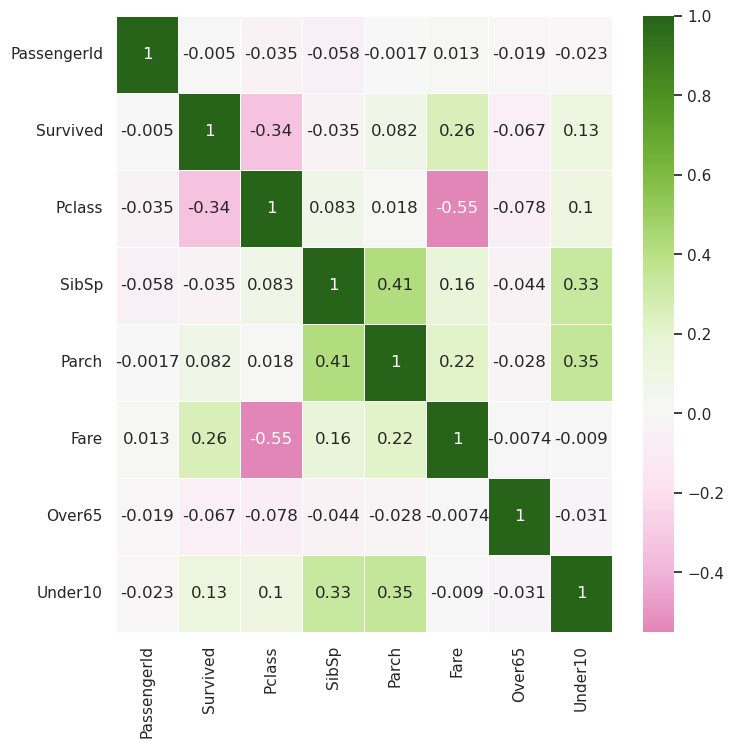

In [24]:
corr_matrix = train.corr('pearson')
plt.subplots(figsize=(8, 8))
sns.heatmap(corr_matrix, cmap="PiYG", center=0, annot=True, linewidths=0.5,)

**Starting first with Survived:**
* There is a strong negative coorelation with Pclass which the Variable Notes tell us is a proxy for socio-economic status (SES)
* There is a strong postive coorelation with Fare which might again be related to SES

**Other Coorelations:**
* A strong negative coorelation between Pclass and Fare again point to a relationship and suggest cash is king and key to life :/
* SibSp (a number of siblings/spouses aboard) and Parch (a number of parents/children aboard) have a relative strong coorelation
* Both SibSp and Parch have a weaker, but noteable coorelation to Fare




#  Let's look closely at our target and most significant features
**Let's look at our continuous dependent variables and determine if they are normally distributed**

**Are there any obvious outliers?**

<AxesSubplot:xlabel='Pclass', ylabel='count'>

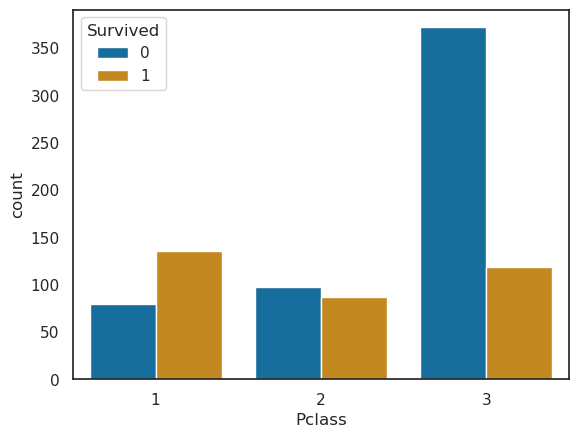

In [25]:
# categorical variable:  Pclass
sns.countplot(data=train, x='Pclass', hue='Survived')

**Pretty clear that 3rd class isn't great for survival...Cash is king :/**
* As Pclass is a non-numeric predictor stored as number, I'll convert to a sting and it will be a categorical variable

In [26]:
train['Pclass'] = train['Pclass'].apply(str)
test['Pclass'] = test['Pclass'].apply(str)

Skewness: 4.787317
Kurtosis: 33.398141


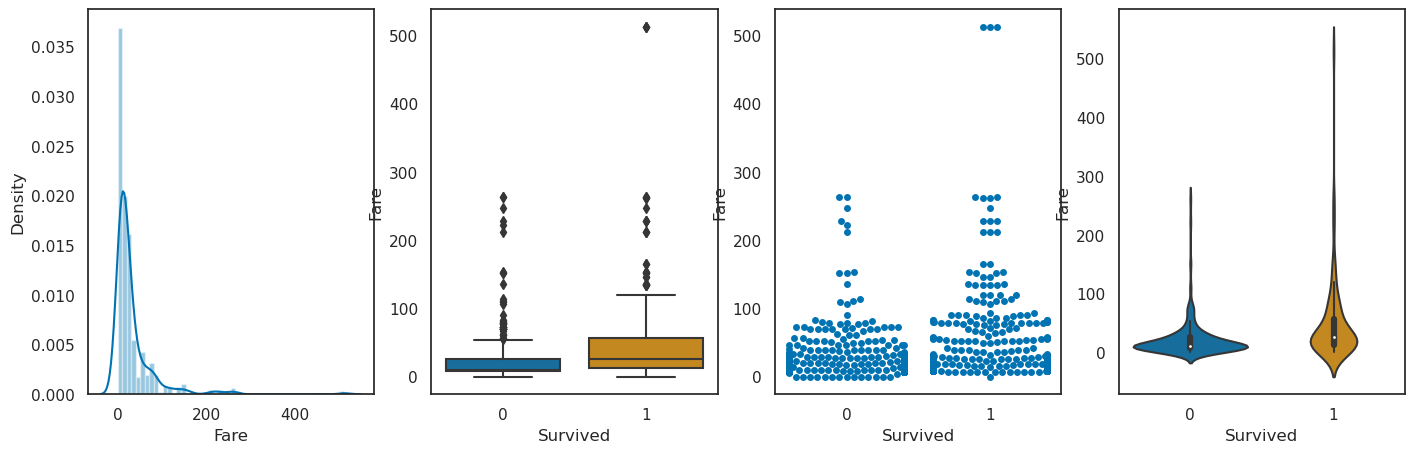

In [27]:
# continuous variable:  Fare
fig, ax = plt.subplots(1,4, figsize =(17, 5))
sns.distplot(train['Fare'], ax=ax[0])
sns.boxplot(train, x = 'Survived', y='Fare', ax=ax[1])
sns.swarmplot(train, x = 'Survived', y='Fare', ax=ax[2])
sns.violinplot(train, x = 'Survived', y='Fare', ax=ax[3])
print("Skewness: %f" % train['Fare'].skew())
print("Kurtosis: %f" % train['Fare'].kurt())

**In literature, acceptable values for skewness are between -0.5 and 0.5 while -2 and 2 for Kurtosis.  Looks like we need to transform Fare.**
* Let's apply Box-cox transformation!

In [28]:
train['Fare_bc'] = boxcox1p(train['Fare'], boxcox_normmax(train['Fare'] + 1))

Skewness: 0.280493
Kurtosis: 1.059326


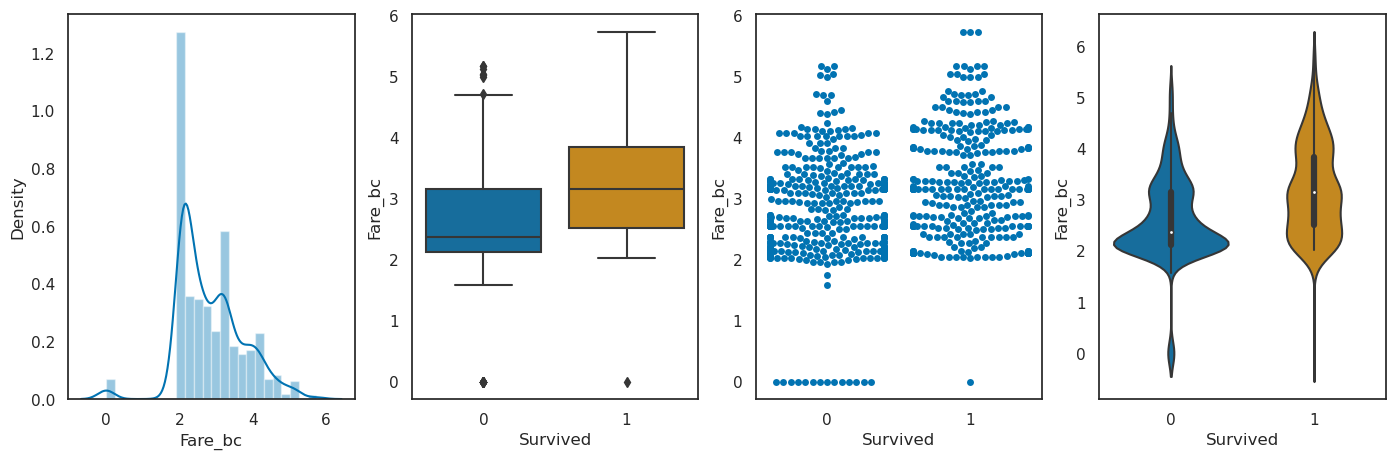

In [29]:
fig, ax = plt.subplots(1,4, figsize =(17, 5))
sns.distplot(train['Fare_bc'], ax=ax[0])
sns.boxplot(train, x = 'Survived', y='Fare_bc', ax=ax[1])
sns.swarmplot(train, x = 'Survived', y='Fare_bc', ax=ax[2])
sns.violinplot(train, x = 'Survived', y='Fare_bc', ax=ax[3])
print("Skewness: %f" % train['Fare_bc'].skew())
print("Kurtosis: %f" % train['Fare_bc'].kurt())

**Much better :)**
We will do the same for the test data at after building the model

In [30]:
train['Fare'] = train['Fare_bc']
train = train.drop(['Fare_bc'], axis=1)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

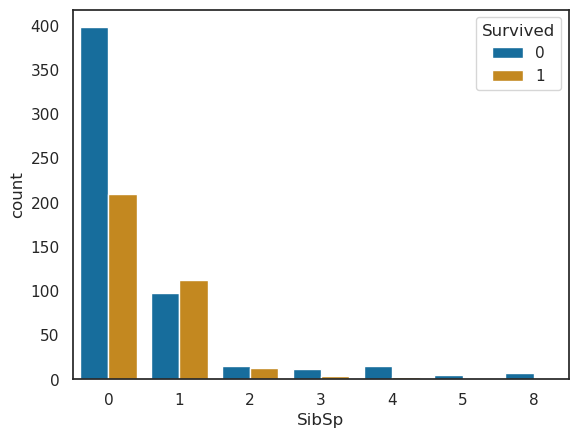

In [31]:
# categorical variable:  SibSp
sns.countplot(data=train, x='SibSp', hue='Survived')

**I think this means that if you had 0 siblings / spouses or more than 3 aboard then you were less likely to survive compared to someone that had 1 or 2?**
* I'll create three new categorical features NoSibSp which = 0 for SibSp>0 and else 1
* SmallSibSp which = 1 for SibSp = 1 or 2 and else 0
* LargeSibSp which = 1 for SibSp >2 else 0

In [32]:
train['NoSibSp'] = 0
train.loc[train['SibSp'] < 1, 'NoSibSp'] = 1
test['NoSibSp'] = 0
test.loc[test['SibSp'] < 1, 'NoSibSp'] = 1

In [33]:
train['SmallSibSp'] = 0
train.loc[(train['SibSp'] > 0) & (train['SibSp'] < 3), 'SmallSibSp'] = 1
test['SmallSibSp'] = 0
test.loc[(test['SibSp'] > 0) & (test['SibSp'] < 3), 'SmallSibSp'] = 1

In [34]:
train['LargeSibSp'] = 0
train.loc[train['SibSp'] > 2, 'LargeSibSp'] = 1
test['LargeSibSp'] = 0
test.loc[test['SibSp'] > 2, 'LargeSibSp'] = 1

In [35]:
train = train.drop(['SibSp'], axis=1)
test = test.drop(['SibSp'], axis=1)

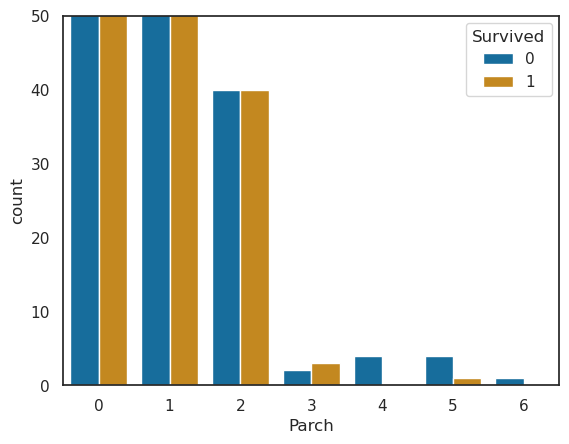

In [36]:
# categorical variable:  Parch
fig, ax = plt.subplots()
sns.countplot(data=train, x='Parch', hue='Survived', ax=ax)
ax.set_ylim(0, 50)
plt.show()

**Same again except small is from 1-3!**

In [37]:
train['NoParch'] = 0
train.loc[train['Parch'] < 1, 'NoParch'] = 1
test['NoParch'] = 0
test.loc[test['Parch'] < 1, 'NoParch'] = 1

In [38]:
train['SmallParch'] = 0
train.loc[(train['Parch'] > 0) & (train['Parch'] < 4), 'SmallParch'] = 1
test['SmallParch'] = 0
test.loc[(test['Parch'] > 0) & (test['Parch'] < 4), 'SmallParch'] = 1

In [39]:
train['LargeParch'] = 0
train.loc[train['Parch'] > 3, 'LargeParch'] = 1
test['LargeParch'] = 0
test.loc[test['Parch'] > 3, 'LargeParch'] = 1

In [40]:
train = train.drop(['Parch'], axis=1)
test = test.drop(['Parch'], axis=1)

**Let's extract the title from the name and see how that looks?**

In [41]:
# need a function to get the title from the name
def get_title(name):
    step_1 = name.split(',')
    step_2 = step_1[1].split('.')
    title = step_2[0].strip()
    return title

In [42]:
names_train = train['Name']
titles_train = []
for name_train in names_train:
    titles_train.append(get_title(name_train))
train['Title'] = titles_train

names_test = test['Name']
titles_test = []
for name_test in names_test:
    titles_test.append(get_title(name_test))
test['Title'] = titles_test

In [43]:
train['Title'].isnull().sum()

0

In [44]:
test['Title'].isnull().sum()

0

In [45]:
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

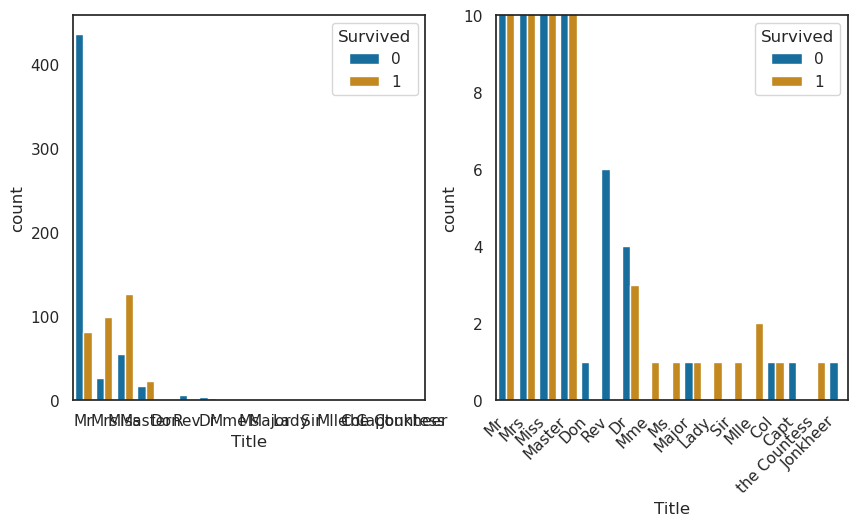

In [46]:
# categorical variable:  Title
fig, ax = plt.subplots(1,2, figsize =(10, 5))
sns.countplot(data=train, x='Title', hue='Survived', ax=ax[0])
sns.countplot(data=train, x='Title', hue='Survived', ax=ax[1])
ax[1].set_ylim(0, 10)
plt.xticks(rotation=45, ha='right')
plt.show()

In [47]:
train['Title'] = train['Title'].replace({'Don':'Rare', 'Mme': 'Rare', 'Ms':'Rare', 'Major': 'Rare',
                                         'Lady': 'Rare', 'Sir': 'Rare', 'Mlle': 'Rare', 'Col': 'Rare', 
                                         'Capt': 'Rare', 'the Countess': 'Rare', 'Jonkheer': 'Rare'})

test['Title'] = test['Title'].replace({'Don':'Rare', 'Mme': 'Rare', 'Ms':'Rare', 'Major': 'Rare',
                                         'Lady': 'Rare', 'Sir': 'Rare', 'Mlle': 'Rare', 'Col': 'Rare', 
                                         'Capt': 'Rare', 'the Countess': 'Rare', 'Jonkheer': 'Rare'})

In [48]:
train['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       14
Dr          7
Rev         6
Name: Title, dtype: int64

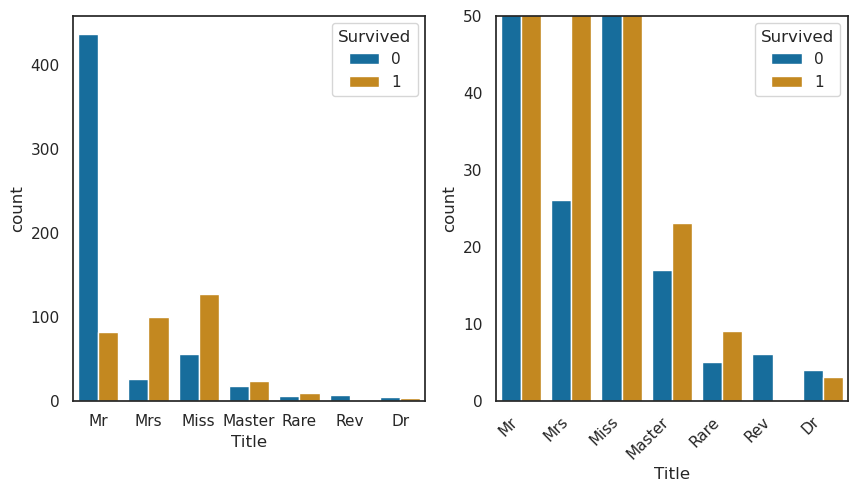

In [49]:
# categorical variable:  Title
fig, ax = plt.subplots(1,2, figsize =(10, 5))
sns.countplot(data=train, x='Title', hue='Survived', ax=ax[0])
sns.countplot(data=train, x='Title', hue='Survived', ax=ax[1])
ax[1].set_ylim(0, 50)
plt.xticks(rotation=45, ha='right')
plt.show()

In [50]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

#  Let's see what that feature engineering did to our coorelations!

<AxesSubplot:>

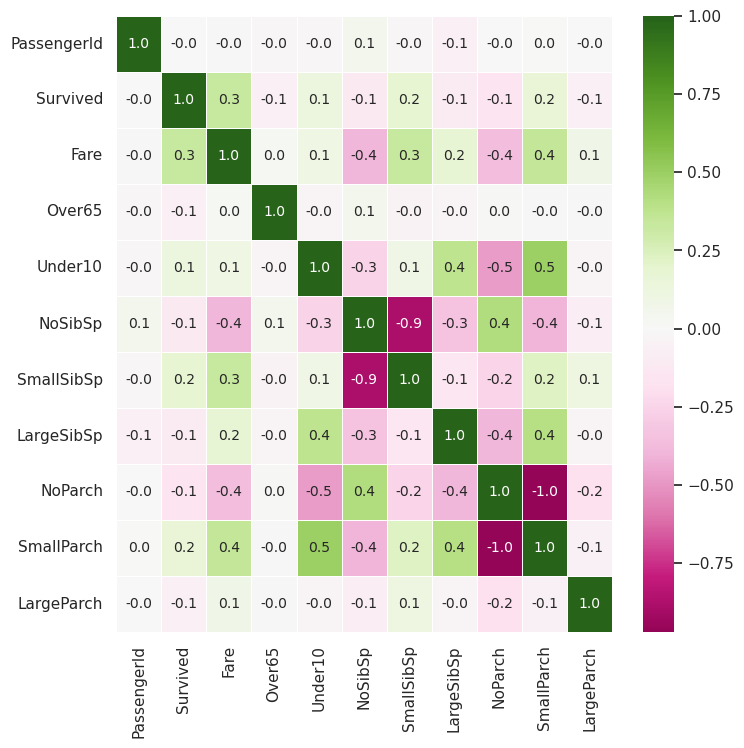

In [51]:
corr_matrix_1 = train.corr('pearson')
plt.subplots(figsize=(8, 8))
sns.heatmap(corr_matrix_1, cmap="PiYG", center=0, annot=True, linewidths=0.5, annot_kws={"size": 10}, fmt='.1f')

**Our new features having more impact!**

#  OneHotEncoding catagorical features

In [52]:
categorical_features = train.select_dtypes(include = ["object"]).columns
print(categorical_features)

Index(['Pclass', 'Sex', 'Ticket', 'Embarked', 'Title'], dtype='object')


**Some of these shouldn't impact Survived...like ticket**

In [53]:
train[['Ticket', 'Survived']].head(10)

,Ticket,Survived
0,A/5 21171,0
1,PC 17599,1
2,STON/O2. 3101282,1
3,113803,1
4,373450,0
5,330877,0
6,17463,0
7,349909,0
8,347742,1
9,237736,1


**Seems like a pain :D I'm dropping them too**

In [54]:
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)

In [55]:
categorical_features = train.select_dtypes(include = ["object"]).columns
print(categorical_features)

Index(['Pclass', 'Sex', 'Embarked', 'Title'], dtype='object')


In [56]:
# Reset the index. Just in case some samples were removed
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

**I'll deal with the test data later**

In [57]:
# Instantiate the OneHotEncoder Object
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse = False, )
# Apply ohe on data
ohe.fit(train[categorical_features])
cat_ohe = ohe.transform(train[categorical_features])

#Create a Pandas DataFrame of the hot encoded column
ohe_train = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = categorical_features))

In [58]:
train = train.drop(categorical_features, axis=1)

In [59]:
#concat with original data and drop original columns
train = pd.concat([train, ohe_train], axis=1)

#  Let's do a final check on our coorelations after onehotencoding!

In [60]:
train = train.drop(['PassengerId'], axis=1)

<AxesSubplot:>

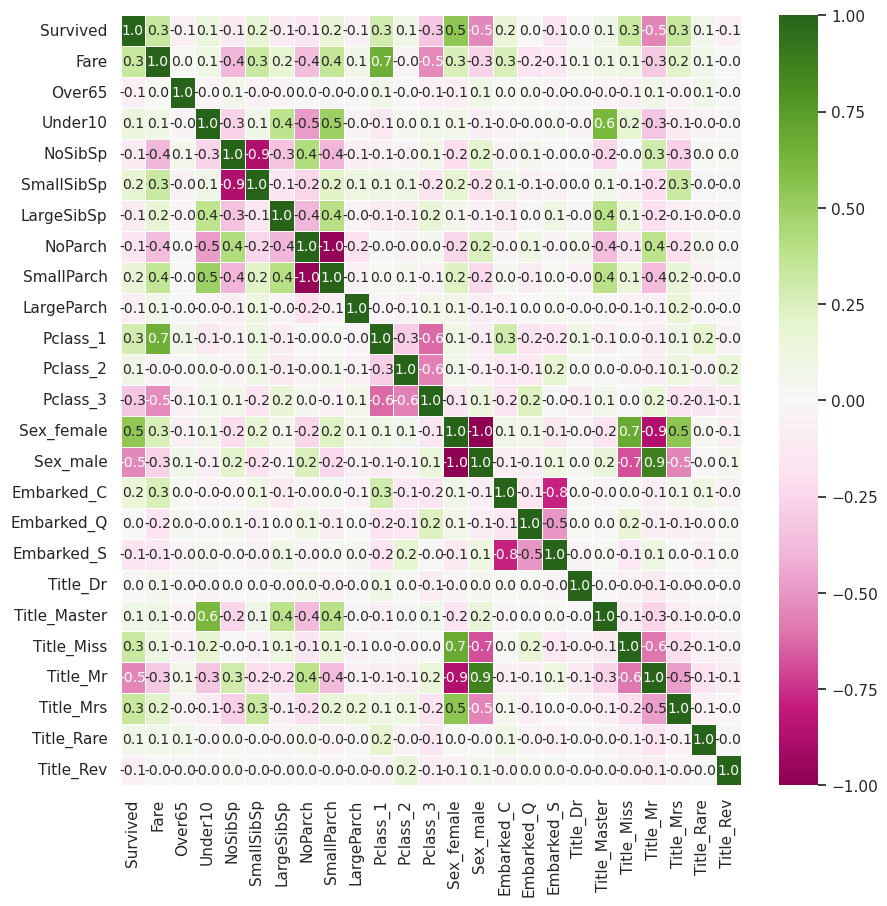

In [61]:
corr_matrix_2 = train.corr('pearson')
plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix_2, cmap="PiYG", center=0, annot=True, linewidths=0.5, annot_kws={"size": 10}, fmt='.1f')

**Yikes low SES men!**

In [62]:
train.head()

,Survived,Fare,Over65,Under10,NoSibSp,SmallSibSp,LargeSibSp,NoParch,SmallParch,LargeParch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Title_Rev
0,0,2.050402,0,0,0,1,0,1,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,4.039238,0,0,0,1,0,1,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,2.124550,0,0,1,0,0,1,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,3.780503,0,0,0,1,0,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,2.137647,0,0,1,0,0,1,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [63]:
test.head()

,PassengerId,Pclass,Sex,Fare,Embarked,Over65,Under10,NoSibSp,SmallSibSp,LargeSibSp,NoParch,SmallParch,LargeParch,Title
0,892,3,male,7.8292,Q,0,0,1,0,0,1,0,0,Mr
1,893,3,female,7.0000,S,0,0,0,1,0,1,0,0,Mrs
2,894,2,male,9.6875,Q,0,0,1,0,0,1,0,0,Mr
3,895,3,male,8.6625,S,0,0,1,0,0,1,0,0,Mr
4,896,3,female,12.2875,S,0,0,0,1,0,0,1,0,Mrs


#  Initial Assessment of a Variety of Models!

In [64]:
y = train['Survived']

In [65]:
X = train.drop(['Survived'], axis=1)

In [66]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (712, 24)
X_test : (179, 24)
y_train : (712,)
y_test : (179,)


**I'm a bit wary of applying StandardScaler to all of the features. I wasn't sure if you are supposed to apply scaling to features than have been OneHotEncoded!?!**

I'll apply StandardScaler method to all the features and see what happens!

In [67]:
X_train.head()

,Fare,Over65,Under10,NoSibSp,SmallSibSp,LargeSibSp,NoParch,SmallParch,LargeParch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Title_Rev
140,2.684080,0,0,1,0,0,0,1,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
439,2.362467,0,0,1,0,0,1,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
817,3.462388,0,0,0,1,0,0,1,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
378,1.576877,0,0,1,0,0,1,0,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
491,2.050402,0,0,1,0,0,1,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [68]:
stdSc_x = StandardScaler()

X_train['Fare'] = stdSc_x.fit_transform(np.array(X_train['Fare']).reshape(-1, 1))
X_test['Fare'] = stdSc_x.transform(np.array(X_test['Fare']).reshape(-1, 1))

In [69]:
X_train.head()

,Fare,Over65,Under10,NoSibSp,SmallSibSp,LargeSibSp,NoParch,SmallParch,LargeParch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Title_Rev
140,-0.165509,0,0,1,0,0,0,1,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
439,-0.530018,0,0,1,0,0,1,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
817,0.716603,0,0,0,1,0,0,1,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
378,-1.420384,0,0,1,0,0,1,0,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
491,-0.883703,0,0,1,0,0,1,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [70]:
# 10 fold cross validatoin
kf = StratifiedKFold(n_splits=10)

In [71]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []

classifiers.append(CatBoostClassifier(random_state=random_state, verbose=False))
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [72]:
cv_results_accuracy = []
for classifier in classifiers :
    cv_results_accuracy.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kf, n_jobs=2))

cv_means_accuracy = []
for cv_result_accuracy in cv_results_accuracy:
    cv_means_accuracy.append(cv_result_accuracy.mean())

cv_accuracy = pd.DataFrame({"CrossValMeans Accuracy":cv_means_accuracy, "Algorithm":["CatBoost","XGB","SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

In [73]:
cv_accuracy

,CrossValMeans Accuracy,Algorithm
0,0.832864,CatBoost
1,0.816041,XGB
2,0.825900,SVC
3,0.816002,DecisionTree
4,0.807492,AdaBoost
5,0.799081,RandomForest
6,0.800528,ExtraTrees
7,0.834233,GradientBoosting
8,0.811854,KNeighboors
9,0.828717,LogisticRegression


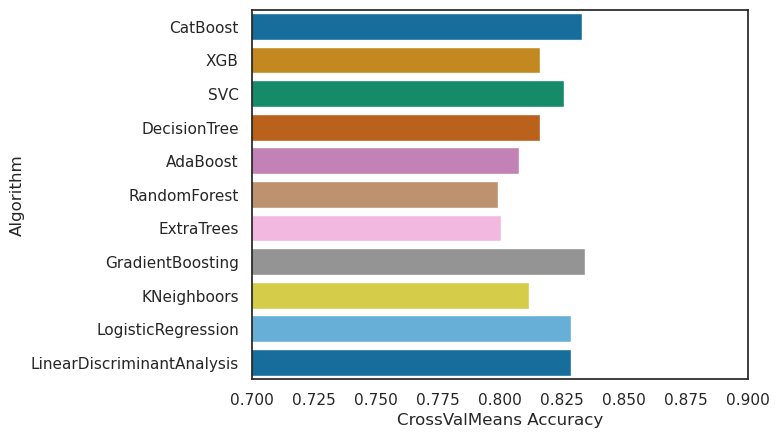

In [74]:
fig, ax = plt.subplots()
sns.barplot(x="CrossValMeans Accuracy",y="Algorithm",data = cv_accuracy, palette="colorblind", orient='h', ax=ax)
ax.set_xlim(0.7, 0.9)
plt.show()

In [75]:
cv_results_auc_roc = []
for classifier in classifiers :
    cv_results_auc_roc.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv = kf, n_jobs=2))

cv_means_auc_roc = []
for cv_result_auc_roc in cv_results_auc_roc:
    cv_means_auc_roc.append(cv_result_auc_roc.mean())

cv_auc_roc = pd.DataFrame({"CrossValMeans Auc Roc":cv_means_auc_roc, "Algorithm":["CatBoost","XGB","SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

In [76]:
cv_auc_roc

,CrossValMeans Auc Roc,Algorithm
0,0.859027,CatBoost
1,0.850689,XGB
2,0.852050,SVC
3,0.799956,DecisionTree
4,0.816782,AdaBoost
5,0.834828,RandomForest
6,0.809037,ExtraTrees
7,0.864236,GradientBoosting
8,0.836223,KNeighboors
9,0.861626,LogisticRegression


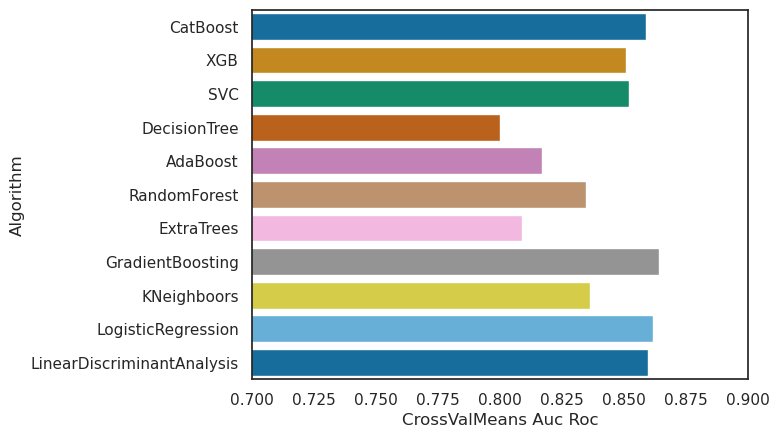

In [77]:
fig, ax = plt.subplots()
sns.barplot(x="CrossValMeans Auc Roc",y="Algorithm",data = cv_auc_roc, palette="colorblind", orient='h', ax=ax)
ax.set_xlim(0.7, 0.9)
plt.show()

#  HyperParameter Tuning of Best Models!
**So ideally I would expand this a bit further but for a first version I'm happy to optimize some Grandient Boosting hyper paramters with grid search!**
* My computer isn't great so I avoid doing this :D

In [78]:
param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

GBC = GradientBoostingClassifier()

In [79]:
GS = GridSearchCV(GBC,
                  param_grid = param_grid, 
                  cv=kf, 
                  scoring="roc_auc",
                  n_jobs= 2,
                  verbose = False)

In [80]:
GS.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=2,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'loss': ['deviance'], 'max_depth': [4, 8],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=False)

In [81]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", GS.best_estimator_)
print("\n The best parameters across ALL searched params:\n", GS.best_params_)
print("\n The best score across ALL searched params:\n", GS.best_score_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingClassifier(max_depth=4, max_features=0.3, min_samples_leaf=100,
                           n_estimators=200)

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 200}

 The best score across ALL searched params:
 0.8640774788303858


#  Select a Final Classifier!
**...Not complete...but good though for version 1!**

In [82]:
classifierGS = GradientBoostingClassifier(learning_rate = 0.1,
                                          loss = 'deviance',
                                          max_depth = 8,
                                          max_features = 0.3,
                                          min_samples_leaf = 100,
                                          n_estimators = 300,
                                          verbose=False)
classifierGS.fit(X_train, y_train)
y_test_predictGS = classifierGS.predict(X_test)
probGS = classifierGS.predict_proba(X_test)
y_test_probGS = probGS[:,1]
y_train_predictGS = classifierGS.predict(X_train)

In [83]:
# Accuracy is a good metric for a balanced dataset
resultGS = accuracy_score(y_test, y_test_predictGS)
print('Accuracy is: ', resultGS*100)

#Log loss is a cost function which tell us how different y_test_pred is from y_test (the higher LL, the larger the error)
llGS = log_loss(y_test, y_test_predictGS)
print('Log Loss is: ', llGS)

# TL: Truely predicted as positives, BR: Truely predicted as negatives, TR: Falsely predicted as negative, BL: Falsely predicted as positive
# Accuracy of confusion matrix is (TL+BR)/attributes 
# recall is Top box from confusion matrix TL / (TL+TR) true positive / total observed positives (closer to 1 the better)
# precision is left box from confusion matris TL / (TL+BL) true postives / all records predicted as positives (closer to 1 the better)
print(confusion_matrix(y_test, y_test_predictGS))
#F1 is accuracy
print(classification_report(y_test, y_test_predictGS))

#Area under ROC
fpr, tpr, threshold = roc_curve(y_test, y_test_probGS)
print('roc_auc_score: ', roc_auc_score(y_test, y_test_probGS)) # the higher the better the model is

Accuracy is:  81.00558659217877
Log Loss is:  6.560496045774054
[[97 13]
 [21 48]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179

roc_auc_score:  0.8887351778656127


In [84]:
classifier = CatBoostClassifier(verbose = False, 
                               thread_count=2)
classifier.fit(X_train, y_train)
y_test_predict = classifier.predict(X_test)
prob = classifier.predict_proba(X_test)
y_test_prob = prob[:,1]
y_train_predict = classifier.predict(X_train)

In [85]:
# Suggested to me that classification report and Auc_roc is best to use

# Accuracy is a good metric for a balanced dataset
result = accuracy_score(y_test, y_test_predict)
print('Accuracy is: ', result*100)

#Log loss is a cost function which tell us how different y_test_pred is from y_test (the higher LL, the larger the error)
ll = log_loss(y_test, y_test_predict)
print('Log Loss is: ', ll)

# TL: Truely predicted as positives, BR: Truely predicted as negatives, TR: Falsely predicted as negative, BL: Falsely predicted as positive
# Accuracy of confusion matrix is (TL+BR)/attributes 
# recall is Top box from confusion matrix TL / (TL+TR) true positive / total observed positives (closer to 1 the better)
# precision is left box from confusion matris TL / (TL+BL) true postives / all records predicted as positives (closer to 1 the better)
print(confusion_matrix(y_test, y_test_predict))

#F1 is accuracy
print(classification_report(y_test, y_test_predict))

#Area under ROC
fpr, tpr, threshold = roc_curve(y_test, y_test_prob)
print('roc_auc_score: ', roc_auc_score(y_test, y_test_prob)) # the higher the better the model is

Accuracy is:  82.68156424581005
Log Loss is:  5.981624937508176
[[99 11]
 [20 49]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       110
           1       0.82      0.71      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179

roc_auc_score:  0.8991436100131752


**Looks like precision is the main issue. Falsely predicting that someone is going to survive!**

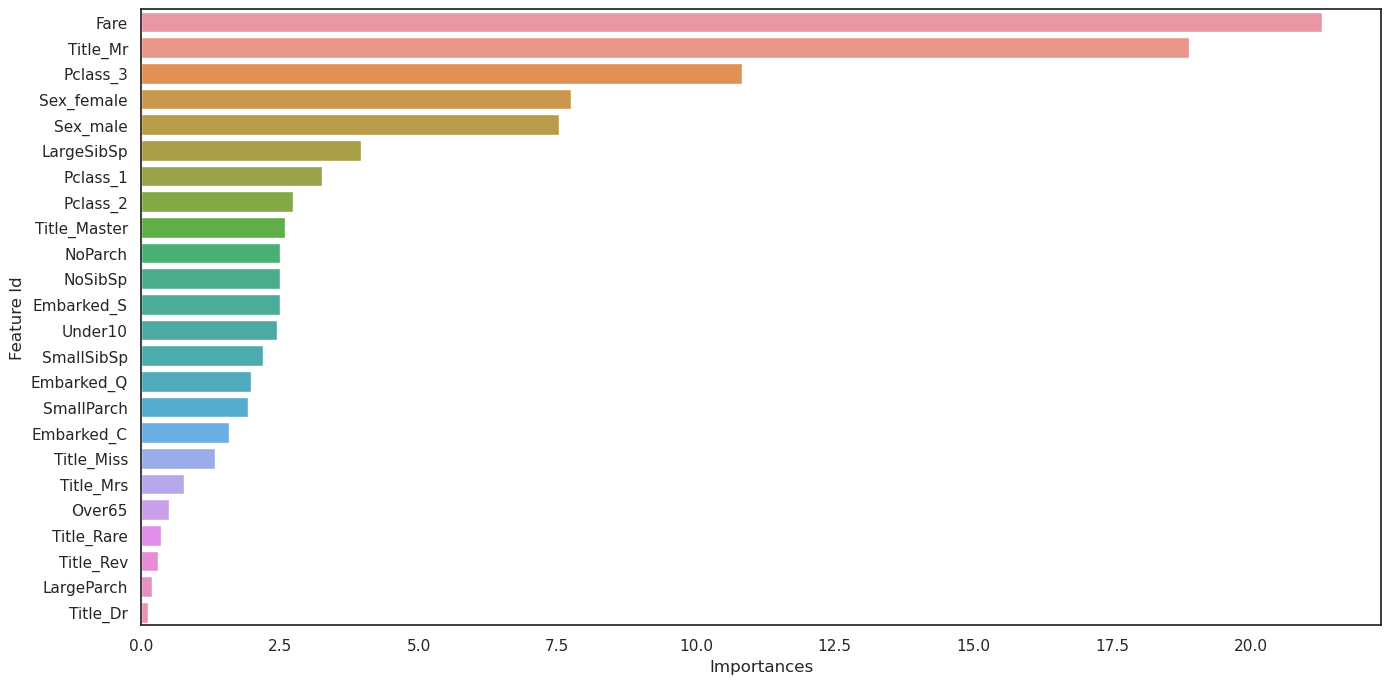

In [86]:
feat_imp = classifier.get_feature_importance(prettified=True)
plt.figure(figsize = (16,8))
sns.barplot(x=feat_imp['Importances'],y=feat_imp['Feature Id'], orient = 'h')
plt.show()

#  Predict Survived on Test!

In [87]:
# Transform Fare as done with the training data
test['Fare'] = boxcox1p(test['Fare'], boxcox_normmax(test['Fare'] + 1))

In [88]:
# Run OneHotEncoder method on the same test categorical features
cat_ohe_test = ohe.transform(test[categorical_features])

#Create a Pandas DataFrame of the hot encoded column
ohe_test = pd.DataFrame(cat_ohe_test, columns = ohe.get_feature_names(input_features = categorical_features))

In [89]:
test = test.drop(categorical_features, axis=1)

In [90]:
#concat with original data and drop original columns
test = pd.concat([test, ohe_test], axis=1)

In [91]:
test_data = test['PassengerId']
test = test.drop(['PassengerId'], axis=1)

In [92]:
print(test.shape)
print(X.shape)

(418, 24)
(891, 24)


In [93]:
test['Fare'] = stdSc_x.transform(np.array(test['Fare']).reshape(-1, 1))

In [94]:
print(test.shape)
print(X.shape)

(418, 24)
(891, 24)


In [95]:
predictions = classifier.predict(test)

In [96]:
output = pd.DataFrame({'PassengerId': test_data, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
